### Model assessment
Here we compared the weights learned by several model iterations, to highlight
- Performance user parameter combinations
- Interpretation based on TF regulators
- Coherence or learned graph-weights when assisting RNA-weights, or only using ATAC-weights

In [1]:
%load_ext autoreload

In [2]:
cd ~/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


/home/ilibarra/.conda/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/.conda/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import torch
import mubind as mb
import scanpy as sc

In [4]:
# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = 'pancreas_multiome_use_logdynamic_%i.pth' % use_logdynamic
    print(p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

pancreas_multiome_use_logdynamic_0.pth
pancreas_multiome_use_logdynamic_1.pth


In [5]:
ad = sc.read_h5ad('atac_train.h5ad')
rna_sample = sc.read_h5ad('rna_sample_train.h5ad')

In [6]:
%load_ext line_profiler

In [7]:
# load the pancreas multiome dataset
rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')


True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_rna_velocities_2024.h5ad
True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_atac.h5ad


In [8]:
# %lprun -f model.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [9]:
# %lprun -f model.binding_modes.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [10]:
import matplotlib.pyplot as plt

False
True
3
order None
0 out of 288...
break


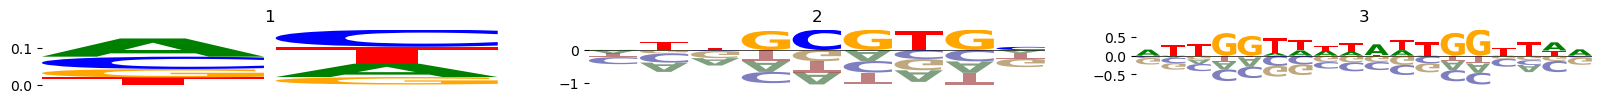

True
True
3
order None
0 out of 288...
break


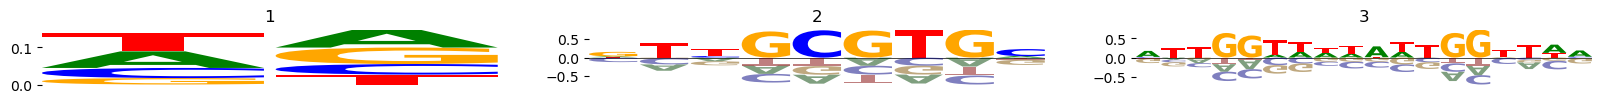

In [11]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4) #  log=True)
    plt.show()


True


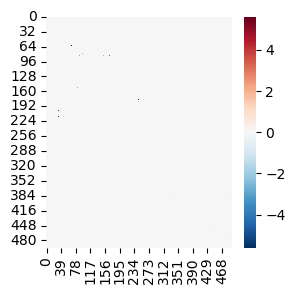

In [12]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

In [13]:
model = model_by_logdynamic[1]

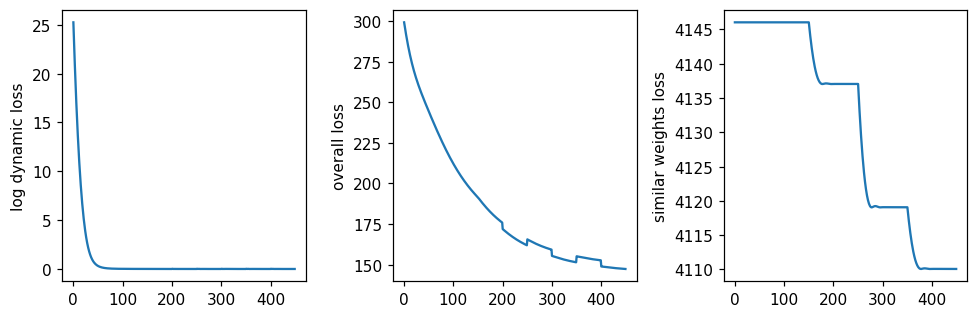

In [14]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')
plt.tight_layout()
plt.show()

In [15]:
model_by_logdynamic

{False: Mubind(
   (padding): ConstantPad2d(padding=(23, 23, 0, 0), value=0.25)
   (binding_modes): BindingLayer(
     (conv_mono): ModuleList(
       (0): None
       (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
       (2): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
       (3): Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
       (4): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
       (5): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
       (6): Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)
       (7): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
       (8-9): 2 x Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
       (10): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
       (11): Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
       (12): Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
       (13): Conv2d(1, 1, kern

In [16]:
import pandas as pd
import numpy as np

False
True


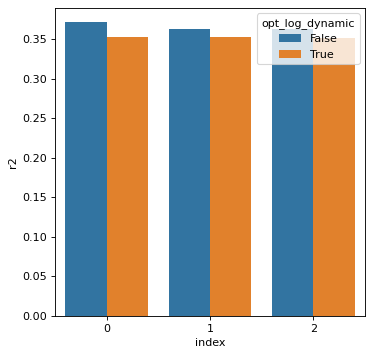

In [17]:
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams['figure.figsize'] = 5, 5
    rcParams['figure.dpi'] = 80
    sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic')
    plt.show()

In [18]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [19]:


#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
# mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
# sns.displot(dynamic_score, height=3, aspect=1.2)
# plt.xlabel('dynamic score (normalized)')


In [20]:
ad.obs['dynamic_score'].describe()

count    496.000000
mean       0.532708
std        0.069737
min        0.000000
25%        0.532691
50%        0.532708
75%        0.532715
max        1.000000
Name: dynamic_score, dtype: float64

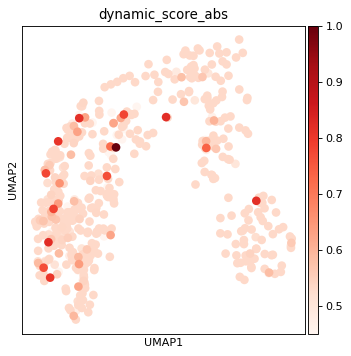

In [21]:
ad.obs['dynamic_score_abs'] = ad.obs['dynamic_score'].abs()
sc.pl.umap(ad, color='dynamic_score_abs', color_map='Reds', vmin=.45)

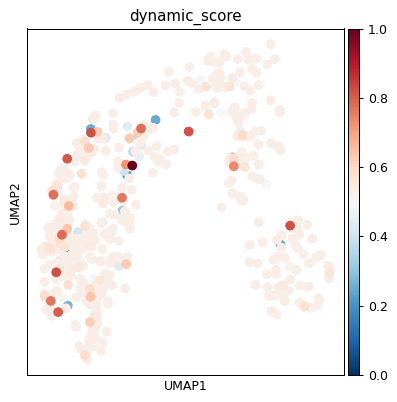

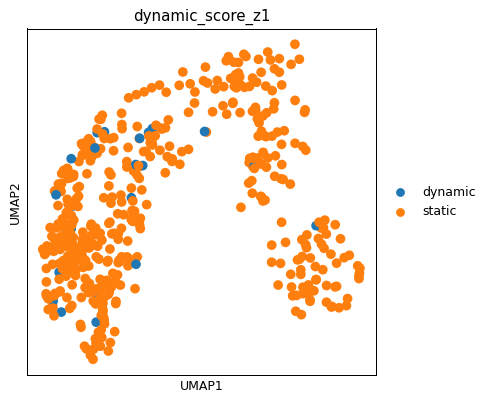

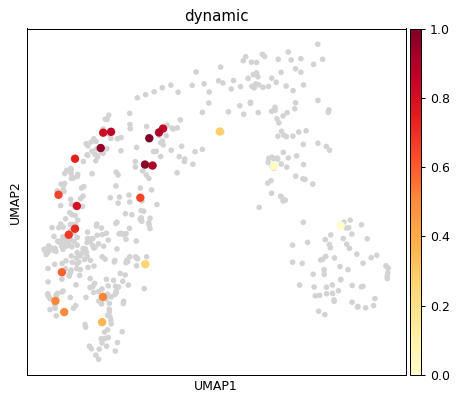

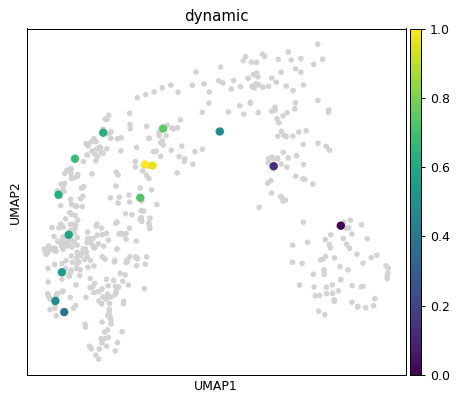

In [22]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic', color_map='viridis') # basis='umap', groupby='dynamic_score_cluster')

<Axes: >

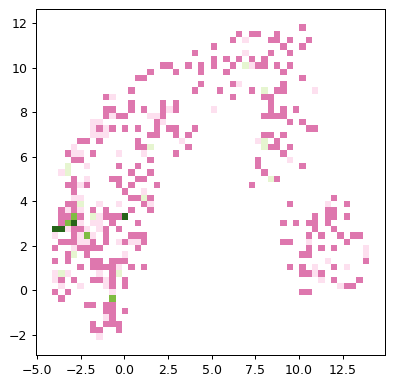

In [23]:
import seaborn as sns
umap = ad.obsm['X_umap']
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap='PiYG')

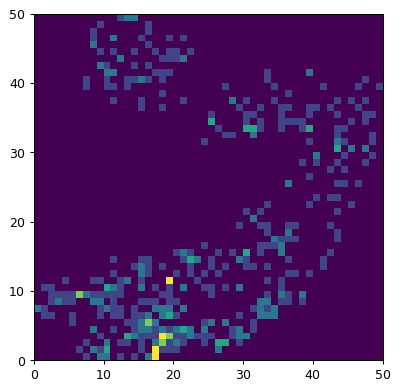

In [24]:
plt.pcolormesh(
    np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0]
)

In [25]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [26]:
x = umap[:,1] # array_txt[:,0]
y = umap[:,1] # array_txt[:,1]
z = ad.obs['dynamic_score'].values # array_txt[:,2]


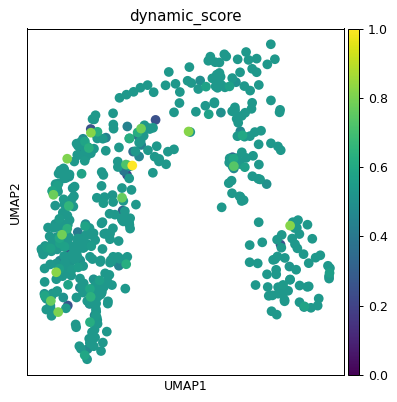

In [27]:
sc.pl.umap(ad, color='dynamic_score')

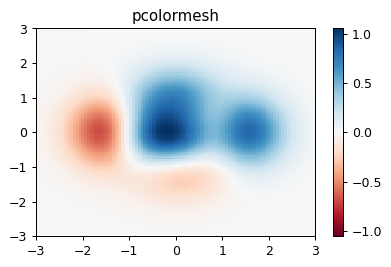

In [28]:
import matplotlib.pyplot as plt
import numpy as np
rcParams['figure.figsize'] = 5, 3

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [29]:
import itertools
import numpy as np

def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)


In [30]:
grid_dyn_score = grid(umap[:,0], umap[:,1], ad.obs['dynamic_score'], size_x=1, size_y=1)
grid_counts = grid(umap[:,0], umap[:,1], ad.obs['celltype'].cat.codes.values, size_x=1, size_y=1)

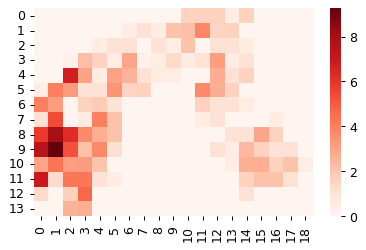

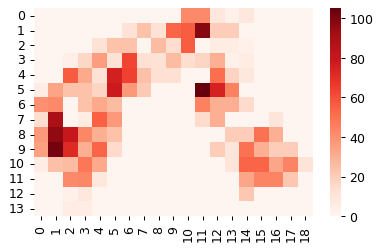

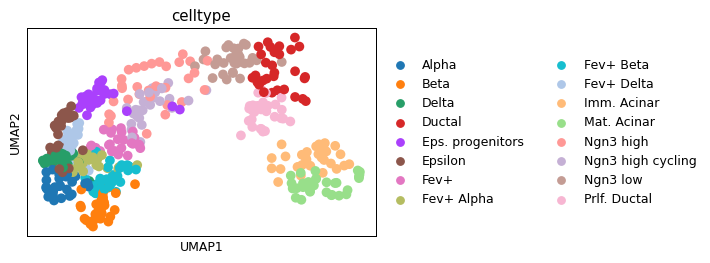

In [31]:

sns.heatmap(grid_dyn_score, cmap='Reds')
plt.show()
sns.heatmap(grid_counts, cmap='Reds')
plt.show()

sc.pl.umap(ad, color='celltype')

In [32]:
# for optimize_log_dynamic in model_by_logdynamic:
#     mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
#     print(optimize_log_dynamic)
#     model = model_by_logdynamic[optimize_log_dynamic]
#     mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
#     plt.show()

#     mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
#     mb.pl.logo(model,
#                title=False,
#                xticks=False,
#                rowspan_dinuc=0,
#                rowspan_mono=1,
#                n_rows=12,
#                n_cols=3,
#                stop_at=20) # n_cols=len(reduced_groups))
#     plt.show()


In [33]:
model = model_by_logdynamic[True]

In [34]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense() # (C, C)

In [35]:
# number of non_zero weights
len(G[G != 0])

870

In [36]:
# output = model(**inputs, use_conn=False, return_binding_scores=True)

In [37]:
print('here...')

here...


In [38]:
ad

AnnData object with n_obs × n_vars = 496 × 250
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'modality', 'acc_score', 'acc_score_rank', 'chr', 'start', 'end', 'summit', 'summit.start', 'summit.end', 'k.summit'
    uns: 'celltype_colors', 'neighbors', 'dynamic_score_z1_colors', 'umap_density_dynamic_score_z1_params', 'umap_density_dynamic_score_z2_params'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    obsp: 'connectivities

In [39]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]

    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'
        output = model(**inputs, use_conn=False, return_binding_scores=True)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T


    # ad.layers['velocity'] = pred
    
    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()
    
    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']
    
    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)


X = ad.X.A
G @ binding_scores
np.random.shuffle(binding_scores)

False
True


NameError: name 'train' is not defined

In [ ]:
import scvelo as scv

In [ ]:
ad
ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

AnnData object with n_obs × n_vars = 496 × 250
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'modality', 'acc_score', 'acc_score_rank', 'chr', 'start', 'end', 'summit', 'summit.start', 'summit.end', 'k.summit'
    uns: 'celltype_colors', 'neighbors', 'dynamic_score_z1_colors', 'umap_density_dynamic_score_z1_params', 'umap_density_dynamic_score_z2_params'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    obsp: 'connectivities

In [ ]:
np.random.shuffle(binding_scores)
binding_scores

NameError: name 'binding_scores' is not defined

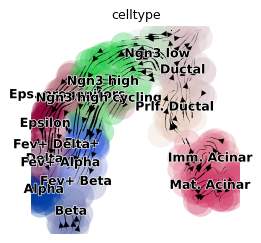

In [ ]:
try:
    scv.pl.velocity_embedding_stream(rna_sample, color='celltype')
except Exception:
    print("sample too small.")

In [ ]:
# np.random.shuffle(binding_scores)
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

<Axes: >

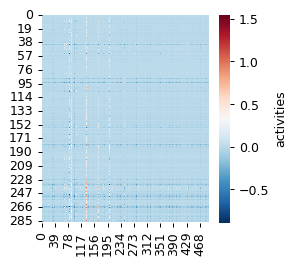

In [ ]:
import seaborn as sns
act = model.get_log_activities().detach().cpu().squeeze(0)
sns.heatmap(act, cmap='RdBu_r', cbar_kws={'label': 'activities'})

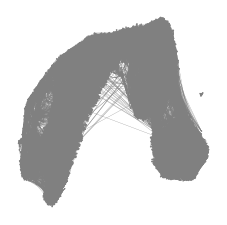

In [ ]:
scv.pl.velocity_graph(rna)

In [ ]:

# ax = scv.pl.velocity_embedding_stream(ad,
#                                       color='celltype',
#                                       # density=2,
#                                       arrow_color='black',
#                                       n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [ ]:
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [ ]:
# scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

## Study the asssociations betweeen obtained weights and cluster-specific transcription factors

Load information from archetypes DB (Vierstra et al 2020)

In [ ]:
rna_sample, ad.shape

(AnnData object with n_obs × n_vars = 496 × 14663
     obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch', 'velocity_self_transition'
     var: 'modality', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
     uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
     obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX', 'velocity_umap'
     layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 

In [ ]:
rna_sel = rna_sample # rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape

(496, 14663)

In [ ]:
pwd

'/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac'

In [ ]:
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'

anno = mb.datasets.archetypes_anno()

In [ ]:
rna_sel.shape
anno.sort_values('Cluster_ID')

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
61,1,HD/1,homeodomain,LHX6_homeodomain_3,12,0,12,2
72,2,HD/2,homeodomain,ALX3_MA0634.1,26,8,16,186
79,3,HD/3,homeodomain,VENTX_homeodomain_2,21,3,20,1
80,4,HD/4,homeodomain,BARX1_MOUSE.H11MO.0.C,17,5,13,17
81,5,HD/5,homeodomain,BARX1_homeodomain_1,21,2,18,6
...,...,...,...,...,...,...,...,...
163,282,PAX/2,PAX,PAX5_HUMAN.H11MO.0.A,24,4,21,3
161,283,PAX-halfsite,PAX,Pax2_MA0067.1,8,1,7,1
0,284,AHR,bHLH,AHR_HUMAN.H11MO.0.B,9,2,8,3
105,285,KLF/SP/3,C2H2,KLF8_HUMAN.H11MO.0.C,9,0,9,2


False


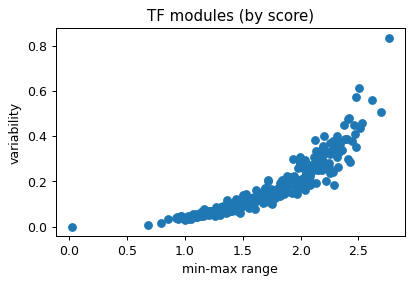

True


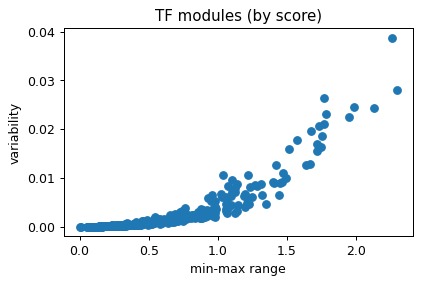

In [ ]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

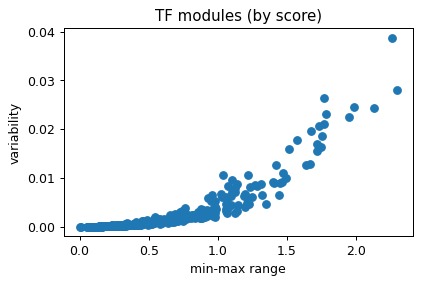

In [ ]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        # print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])


In [ ]:
res.sort_values('spearman', ascending=False)

,opt_log_dynamic,archetype_id,spearman,p_val
198,True,197,0.124166,5.621909e-03
197,True,196,0.091314,4.207559e-02
196,True,195,0.091012,4.276184e-02
24,True,23,0.090738,4.339318e-02
20,True,19,0.089090,4.736103e-02
...,...,...,...,...
276,True,275,-0.150450,7.755753e-04
105,True,104,-0.152951,6.310446e-04
93,True,92,-0.153033,6.267201e-04
252,True,251,-0.231308,1.895678e-07


In [ ]:
res = pd.DataFrame(pd.concat([delta, var], axis=1))
res['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
res['archetypes_name'] = res['name'].map(anno.set_index('Cluster_ID')['Name'])
res['archetypes_seed'] = res['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])
res = res.sort_values(0, ascending=0)
res

,0,1,name,archetypes_name,archetypes_seed
93,2.294650,2.799027e-02,93,SOX/4,SOX10_HMG_1
264,2.258809,3.875221e-02,264,TFAP2/1,AP2A_HUMAN.H11MO.0.A
40,2.130499,2.440484e-02,40,NR/11,ERR2_MOUSE.H11MO.0.A
234,1.982815,2.465761e-02,234,P53-like/3,Tp53.mouse_p53l_1
92,1.950196,2.252049e-02,92,SOX/3,SOX10_HMG_4
...,...,...,...,...,...
139,0.062971,1.816895e-05,139,AIRE,AIRE_HUMAN.H11MO.0.C
66,0.052202,1.154157e-05,66,SCRT1,SCRT1_C2H2_1
94,0.051317,1.471505e-05,94,SOX/5,SOX10_HMG_3
dinuc_bias,0.013640,3.666626e-07,dinuc_bias,NaN,NaN


## Observe general scores per case

<Axes: xlabel='0', ylabel='archetypes_name'>

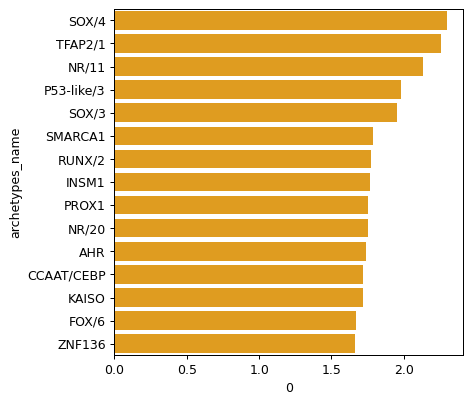

In [ ]:
rcParams['figure.figsize'] = 5, 5
sns.barplot(data=res.head(15), x=0, y='archetypes_name', color='orange')

In [ ]:
res.head(20)

,0,1,name,archetypes_name,archetypes_seed
93,2.294650,0.027990,93,SOX/4,SOX10_HMG_1
264,2.258809,0.038752,264,TFAP2/1,AP2A_HUMAN.H11MO.0.A
40,2.130499,0.024405,40,NR/11,ERR2_MOUSE.H11MO.0.A
234,1.982815,0.024658,234,P53-like/3,Tp53.mouse_p53l_1
92,1.950196,0.022520,92,SOX/3,SOX10_HMG_4
250,1.785900,0.023231,250,SMARCA1,SMCA1_HUMAN.H11MO.0.C
178,1.769878,0.021021,178,RUNX/2,RUNX2_RUNX_2
266,1.769112,0.026388,266,INSM1,INSM1_HUMAN.H11MO.0.C
238,1.754429,0.018603,238,PROX1,PROX1_MA0794.1
248,1.749901,0.016336,248,NR/20,ANDR_MOUSE.H11MO.0.A


True
1
order None
0 out of 288...
10 out of 288...
break


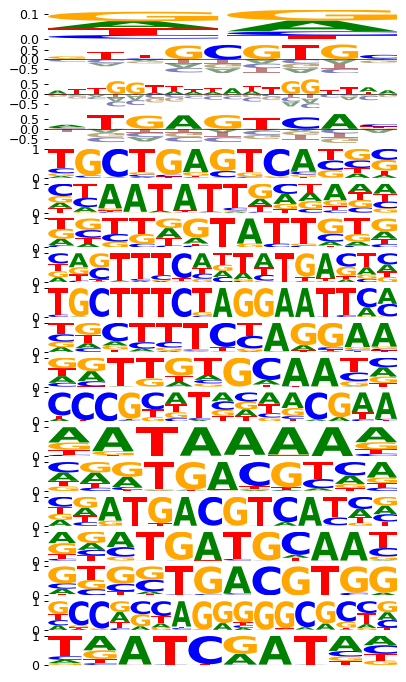

In [ ]:
# visualize the logos as obtained by the model in each step
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

True
1
order Index([ 93, 264,  40, 234,  92, 250, 178, 266, 238, 248, 284,  52, 155,  87,
       227, 279, 179, 251,  56, 164],
      dtype='object')
0 out of 288...
10 out of 288...


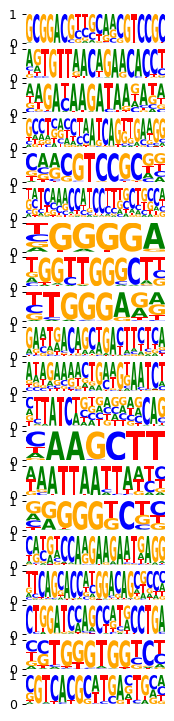

<Figure size 180x1800 with 0 Axes>

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 10.767716


In [ ]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [ ]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [ ]:
def find_varname(ad, k):
    return ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]

In [ ]:
from scipy.stats import spearmanr

Calculate global correlations between the activities obtained per motif and gene-specific expression

In [ ]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')


False
True


In [ ]:


print('association between motif activities and related TF targets ')
res = []
print(len(all_targets))

rna_sel_df = rna_sel.to_df()

for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    log_act = ad.obsm['log_activities'][k].values
    for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
        # print(ki)
        if ki % 30 == 0:
            print(ki)
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        next_targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            # print(name, target)
            for t in target:
                next_targets.add(t)

        # for t in all_targets:
        for t in set(all_targets).intersection(next_targets):
            gex = rna_sel_df[[t]].to_numpy() # rna_sel_df[t].A
            assert gex.shape[1] == 1
            gex = gex.flatten()
            # print(log_act.shape, gex.shape)
            # print(t, pearsonr(log_act, gex))
            res.append([optimize_log_dynamic, k, t, t in next_targets] +
                       list(spearmanr(log_act, gex)))
            
res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

# p-values
res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])

# p-val adjust
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
res[res['p_adj'] < 0.1]

association between motif activities and related TF targets 
3828
False
0
30
60
90
120
150
180
210
240
270
True
0
30
60
90
120
150
180
210
240
270


,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
91,False,32,Rara,True,-0.121344,6.817006e-03,NR/3,8.998867e-02
103,False,34,Thrap3,True,0.144409,1.259935e-03,NR/5,2.729032e-02
114,False,40,Rara,True,-0.121344,6.817006e-03,NR/11,8.998867e-02
123,False,41,Rara,True,-0.121344,6.817006e-03,NR/12,8.998867e-02
134,False,42,Rara,True,-0.121344,6.817006e-03,NR/13,8.998867e-02
...,...,...,...,...,...,...,...,...
8759,True,258,Grhl2,True,0.261626,3.312063e-09,GRHL,7.103971e-07
8765,True,261,Glis3,True,0.200790,6.590921e-06,GLIS,4.261806e-04
8780,True,264,Rap2b,True,0.130849,3.507647e-03,TFAP2/1,5.670267e-02
8782,True,266,Insm1,True,-0.134945,2.599073e-03,INSM1,4.606881e-02


In [ ]:
res.sort_values('p_adj')

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
4398,True,2,Isl1,True,-0.429776,1.028541e-23,HD/2,9.044990e-20
5012,True,70,St18,True,-0.378789,2.277260e-18,TBX/1,1.001311e-14
4992,True,70,Ctsf,True,-0.363154,6.580894e-17,TBX/1,1.929079e-13
5630,True,70,Auts2,True,-0.346544,1.926884e-15,TBX/1,4.236255e-12
6731,True,70,Zbtb20,True,-0.343917,3.228096e-15,TBX/1,5.677574e-12
...,...,...,...,...,...,...,...,...
1477,False,70,Matk,True,0.000110,9.980454e-01,TBX/1,1.000000e+00
5184,True,70,Tdrd1,True,0.000238,9.957783e-01,TBX/1,1.000000e+00
1313,False,70,Zbtb37,True,-0.000143,9.974674e-01,TBX/1,1.000000e+00
1299,False,70,Tmem229a,True,-0.000222,9.960724e-01,TBX/1,1.000000e+00


In [ ]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot(index='k', columns='opt_log_dynamic', values='spearman')
# df2 = res # .pivot(index='k', columns='opt_log_dynamic', values='spearman')

In [ ]:
df2

opt_log_dynamic,False,True
k,,
A3galt2_70,-0.064535,0.050226
Aar2_248,0.032922,-0.033016
Aard_248,0.002888,-0.017997
Aars2_248,-0.020427,0.070287
Aars_248,0.113932,-0.033129
...,...,...
mt-Nd3_70,0.070864,0.047430
mt-Nd4_70,0.155095,-0.031582
mt-Nd4l_70,0.071277,0.064750


In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
# df2 = df2.sort_values('matched', ascending=True)
# plt.scatter(df2[True], df2[True],
#             color=np.where(df2['matched'], 'blue', 'gray'),
#             s=np.where(df2['matched'], 30, 5))
# plt.xlabel('TF activity (graph = off)')
# plt.ylabel('TF activity (graph = on)')
# plt.axhline(0, color='gray', ls='--', zorder=0)
# plt.axvline(0, color='gray', ls='--', zorder=0)


In [ ]:
# df2[df2['matched'] == True].sort_values(True, ascending=False)

False


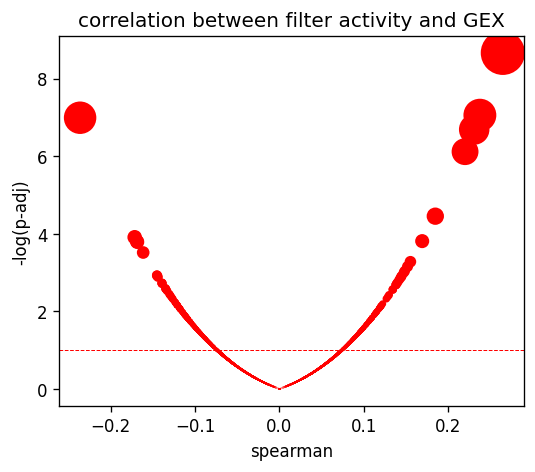

True


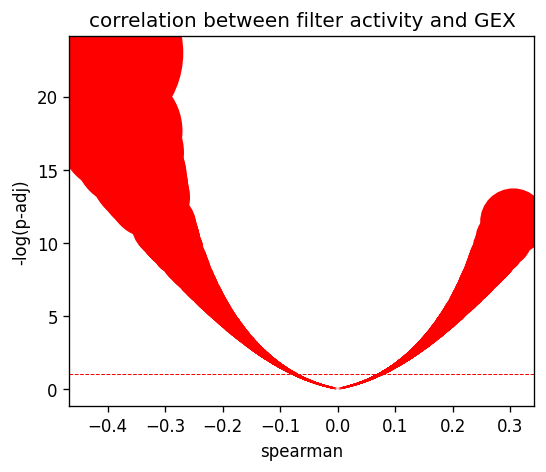

In [ ]:
for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    print(optimize_log_dynamic)
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 3), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('correlation between filter activity and GEX')
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

In [ ]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

In [ ]:
res[res['p_val'] < 0.1]

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
5,False,2,Nkx6-1,True,0.096053,3.245658e-02,HD/2,2.388478e-01,Nkx6-1_2
7,False,2,Dlx1as,True,-0.074741,9.637652e-02,HD/2,4.261111e-01,Dlx1as_2
9,False,2,Tsen15,True,0.113461,1.144907e-02,HD/2,1.264863e-01,Tsen15_2
16,False,2,Abraxas2,True,0.112343,1.229345e-02,HD/2,1.322277e-01,Abraxas2_2
19,False,2,Arxes2,True,-0.078562,8.047134e-02,HD/2,3.843916e-01,Arxes2_2
...,...,...,...,...,...,...,...,...,...
8781,True,265,Ctcf,True,0.084678,5.949760e-02,CTCF,3.317831e-01,Ctcf_265
8782,True,266,Insm1,True,-0.134945,2.599073e-03,INSM1,4.606881e-02,Insm1_266
8783,True,268,Plag1,True,-0.100467,2.525148e-02,PLAG1,2.090974e-01,Plag1_268
8788,True,281,Pax6os1,True,-0.077228,8.576558e-02,PAX/1,3.959173e-01,Pax6os1_281


In [ ]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

In [ ]:
# sc.pl.umap(rna_sel, color=sel_genes,
#            cmap='Reds', ncols=3)


In [ ]:
import anndata
ad_act = anndata.AnnData(ad.obsm['log_activities'])
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

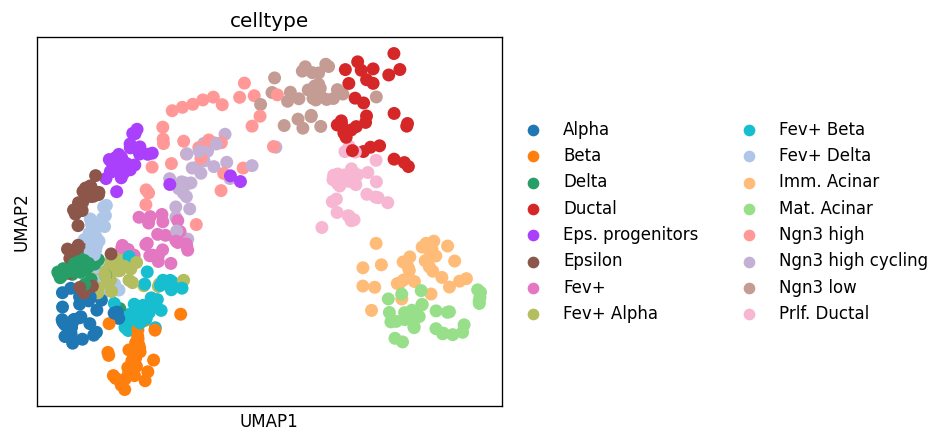

In [ ]:
sc.pl.umap(ad_act, color='celltype')


Rank genes groups using the annotation

In [ ]:
sc.tl.rank_genes_groups(ad_act, 'celltype')
rkg_df = []
for ct in ad_act.obs['celltype'].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2['celltype'] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

Fev+ Delta
Prlf. Ductal
Fev+
Ductal
Beta
Eps. progenitors
Fev+ Beta
Fev+ Alpha
Epsilon
Ngn3 high
Ngn3 low
Ngn3 high cycling
Alpha
Imm. Acinar
Delta
Mat. Acinar


,names,scores,logfoldchanges,pvals,pvals_adj,celltype,module_name
0,156,1.762303,0.869740,0.082653,0.136804,Fev+ Delta,156
1,214,1.577165,0.665614,0.117059,0.180284,Fev+ Delta,214
2,86,1.486536,1.142673,0.141236,0.209670,Fev+ Delta,86
3,43,1.454341,0.641832,0.148385,0.218035,Fev+ Delta,43
4,85,1.353754,1.393609,0.180206,0.250722,Fev+ Delta,85


Get top modules

In [ ]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

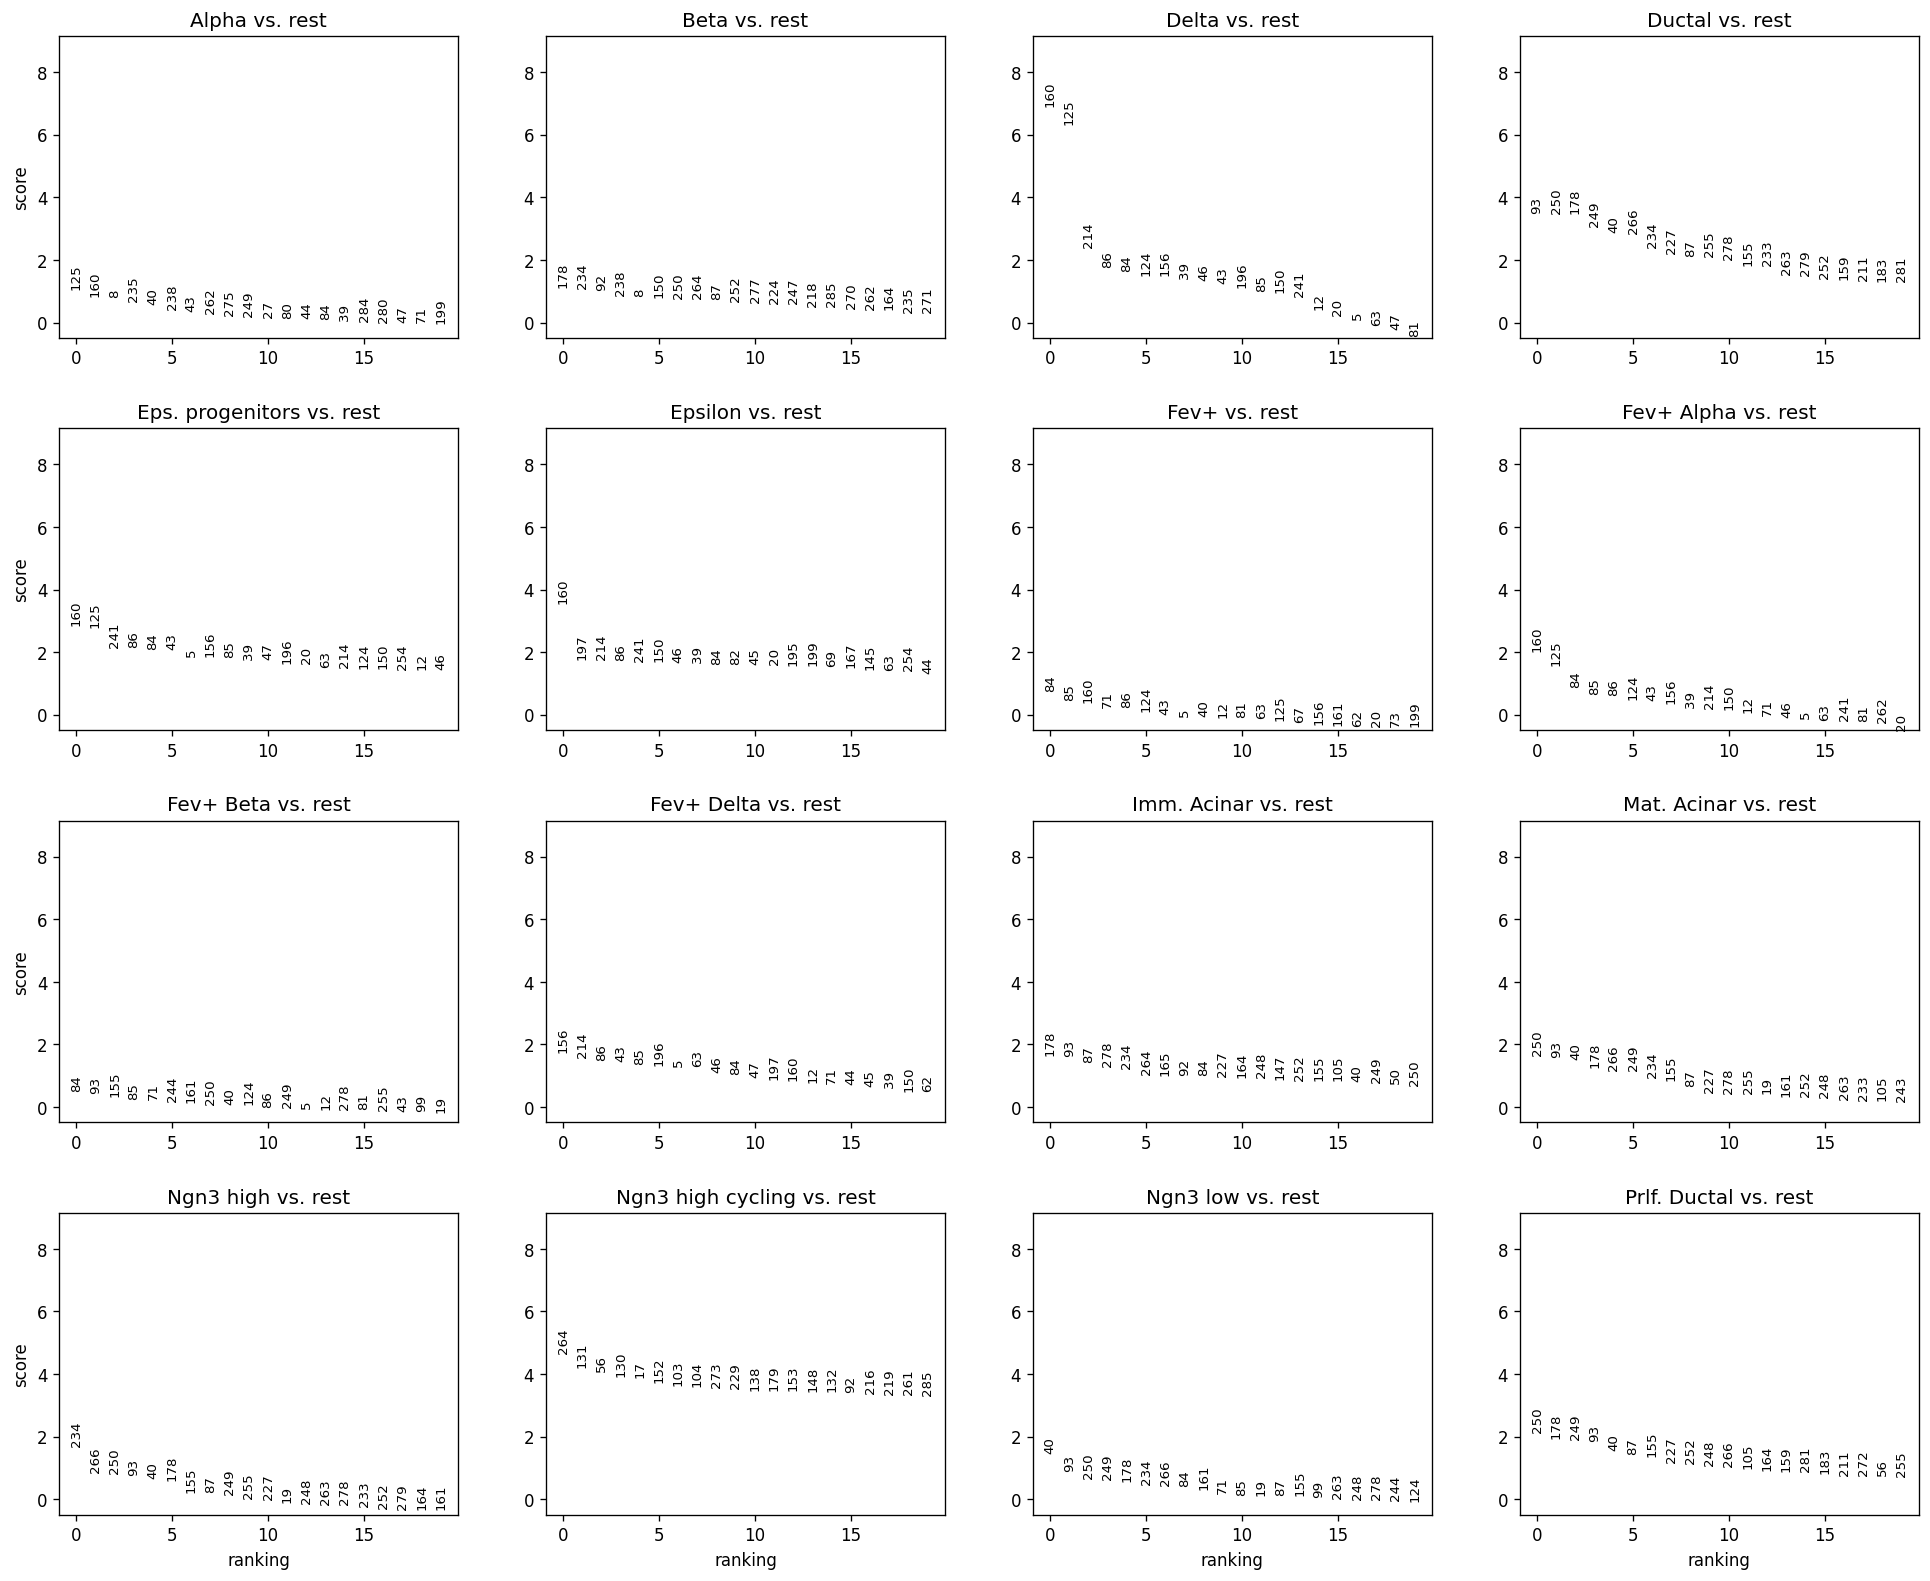

In [ ]:
sc.tl.rank_genes_groups(ad_act, 'celltype')
sc.pl.rank_genes_groups(ad_act)


In [ ]:
len(set(res[(res['p_adj'] < 1e-5)]['k']))

69

In [ ]:
set(res[(res['p_adj'] < 1e-5)]['k'])

{'Acot1_32',
 'Acot1_41',
 'Acot1_70',
 'Adamts16_70',
 'Adamts1_70',
 'Adamts9_70',
 'Arg1_248',
 'Arx_2',
 'Arx_248',
 'Arx_8',
 'Atp2b1_70',
 'Atp5l_70',
 'Atp6v0b_70',
 'Auts2_70',
 'Ctsf_70',
 'Dbpht2_52',
 'Dbpht2_70',
 'Dst_70',
 'Flrt2_70',
 'Gprasp1_109',
 'Gprasp1_112',
 'Gprasp2_109',
 'Grhl2_258',
 'Gsta3_70',
 'Gstz1_70',
 'Hes1_59',
 'Hmga2_71',
 'Hmga2_73',
 'Isl1_2',
 'Jarid2_248',
 'Jarid2_58',
 'Kctd8_70',
 'Malat1_70',
 'Mboat4_70',
 'Mecom_241',
 'Meis2_69',
 'Mgst1_70',
 'Mt1_70',
 'Myt1_70',
 'Nfib_189',
 'Pax6_281',
 'Ptma_70',
 'Ptn_70',
 'Ptprg_70',
 'Ptprn2_70',
 'Rest_151',
 'Rest_70',
 'Rfx6_246',
 'Runx1t1_179',
 'Runx1t1_70',
 'Serf2_98',
 'Sptan1_70',
 'St18_70',
 'Stmn1_70',
 'Stxbp5l_70',
 'Sytl5_70',
 'Tcp11_70',
 'Tcp11l2_70',
 'Tead2_166',
 'Tead2_70',
 'Tkt_70',
 'Tmem108_70',
 'Tro_70',
 'Ttyh1_70',
 'Tubb5_70',
 'Tyms_70',
 'Ugt2b34_70',
 'Zbtb20_70',
 'mt-Co3_70'}

In [ ]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
4398,True,2,Isl1,True,-0.429776,1.028541e-23,HD/2,9.044990e-20,Isl1_2
4400,True,2,Arx,True,-0.277976,2.980687e-10,HD/2,9.708207e-08,Arx_2
4438,True,8,Arx,True,-0.277976,2.980687e-10,HD/8,9.708207e-08,Arx_8
4405,True,2,Fen1,True,0.179080,6.053763e-05,HD/2,2.688727e-03,Fen1_2
4437,True,7,Fen1,True,0.179080,6.053763e-05,HD/7,2.688727e-03,Fen1_7
...,...,...,...,...,...,...,...,...,...
34,False,7,Ten1,True,-0.005710,8.990527e-01,HD/7,9.710476e-01,Ten1_7
13,False,2,Pou6f1,True,-0.004959,9.122780e-01,HD/2,9.769227e-01,Pou6f1_2
4408,True,2,Gbx1,True,-0.003430,9.392619e-01,HD/2,9.843410e-01,Gbx1_2
29,False,2,Psen1,True,0.002496,9.557879e-01,HD/2,9.898078e-01,Psen1_2


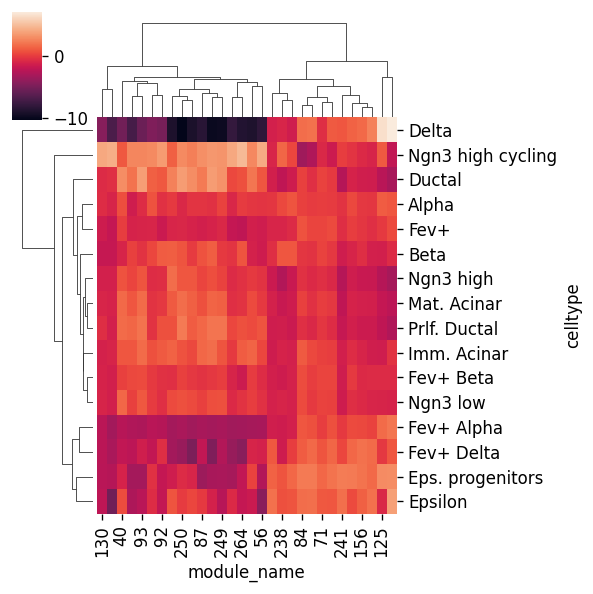

In [ ]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby('celltype').head(5)['module_name'])
sns.clustermap(rkg_df[rkg_df['module_name'].isin(mod_names_best)].pivot(index='celltype', columns='module_name', values='scores'), figsize=[5, 5])


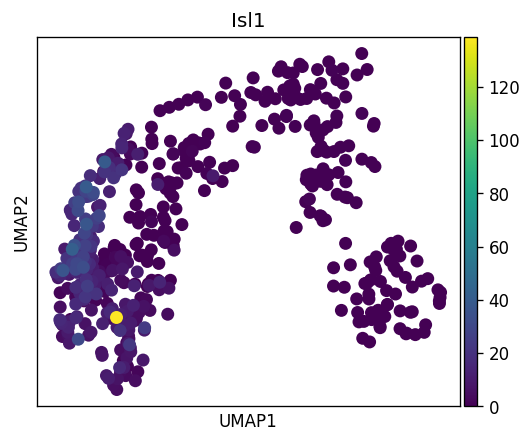

In [ ]:
sc.pl.umap(rna_sel, color='Isl1')


In [ ]:
# rna_sel['Ehf']

In [ ]:
from matplotlib import rcParams, cm
cmap = cm.get_cmap('YlOrRd')
cmap.set_over('black')
cmap.set_under('lightgray')

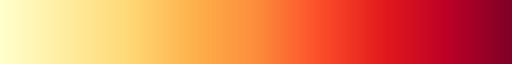

In [ ]:
cmap

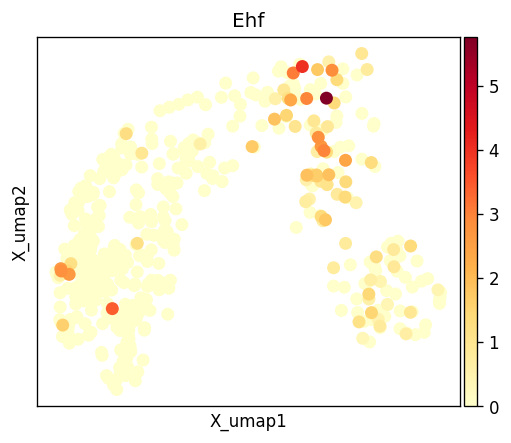

In [ ]:
sc.pl.embedding(rna_sel, basis='X_umap', color='Ehf', color_map=cmap)
